# 4. Validation

[*This is part 4 of a 6-part tutorial on machine learning in scikit-learn.*]


Now that we have a basic handle on overfitting (and underfitting), we can start thinking about ways to minimize the problem. In a sense, each of the remaining sections in this tutorial focuses on a different kind of solution. In this section, we'll talk about model validation. While model validation doesn't *directly* prevent overfitting, it plays an important indirect role. If we don't have a good way to recognize overfitting when it happens, we're not going to be in a great position to mitigate it.

Let's start the way we always do: we'll import the tools we need, and read in the data.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

#scikit-learn stuff we've seen before
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

%matplotlib inline

In [2]:
# Read in the ABIDE-II dataset
data = pd.read_csv('data/abide2.tsv', sep='\t')

# Assign all brain features to X_all for convenience
X_all = data.filter(like='fs')

# We'll use age as our target throughout the notebook
y = data['age']

## Cross-validation
An important insight we introduced in the last section is that an estimator will almost always perform better when evaluated on the same data it was trained on than when evaluated on an entirely new dataset. Since our estimators are of little use to us unless they can generalize to new data, we should probably care much more about how an estimator performs on new data than on data it's already seen. That is, we want what's known as an **out-of-sample** estimate of performance.

The most straightforward way to estimate out-of-sample performance is to ensure that we always train and evaluate our estimator on independent datasets. The performance estimate obtained from the training dataset will typically suffer from overfitting to some degree; the test dataset estimate will not, so long as its error is independent of the training dataset.

In practice, an easy way to construct training and test datasets with independent errors is to randomly split a dataset in two. We can make use of scikit-learn's `train_test_split` utility, found in the [model selection](https://scikit-learn.org/stable/modules/classes.html#module-sklearn.model_selection) module, to do the work for us.

In [3]:
# a helpful utility that splits an arbitrary number of
# array-like objects into training and testing subsets
from sklearn.model_selection import train_test_split

# for every array we pass to train_test_split, we get back
# two: a training set, and a test set. the train_size
# parameter controls the proportion of all cases assigned
# to the training set (the remainder are assigned to test).
split_vars = train_test_split(X_all, y, train_size=0.5)

# Python supports parallel assignment: if the number of
# variables on the left side matches the number of
# elements in a list, the list elements will be mapped
# one-to-one onto the variables.
X_train, X_test, y_train, y_test = split_vars

# Verify shape...
X_train.shape

(502, 1440)

Now we can fit our estimator using the training data, and evaluate its performance using both the training and test data. The difference between the two will tell us how badly we're overfitting to the training data. This practice is called **cross-validation**, and it's ubiquitous in machine learning. In most applications, if you report performance estimates from your training dataset without also reporting a corresponding cross-validated estimate, there's a good chance someone will (not unreasonably) yell at you.

In [4]:
est = LinearRegression()

est.fit(X_train, y_train)

# Estimate R^2 separately for the training and test samples
r2_train = est.score(X_train, y_train)
r2_test = est.score(X_test, y_test)

print(f"R^2 in training sample: {round(r2_train, 2)}")
print(f"R^2 in test sample: {round(r2_test, 2)}")

R^2 in training sample: 1.0
R^2 in test sample: -0.55


The difference here is remarkable. In the training sample, the fitted model explains all of the variance. In the test sample, it explains... well, none. Actually, the value is negative! (If you're used to computing $R^2$ by taking the square of a correlation coefficient, you might think this is an error, but it isn't. The [standard definition of $R^2$](https://en.wikipedia.org/wiki/Coefficient_of_determination) allows arbitrarily large negative values, because the residual sum-of-squares (RSS) can be larger than the total sum-of-squares (TSS). Intuitively, we can have an estimator that's so bad, we would have been better off just using the mean of the new data as our prediction.)

#### When less is more
The reason our linear regression model overfits our data in this case is that, just as we saw in the simulated examples above, the model has too much flexibility relative to the data. You might intuitively think that 500 subjects would be enough to prevent overfitting, but sadly there's no such heuristic. What matters is the flexibility of the model *in relation to* the amount of available training data. In our case, even if we think 500 subject is a large number, we still have far more features than subjects:

In [5]:
X_train.shape

(502, 1440)

A simple way to mitigate overfitting is to use fewer features. Let's see what happens if we randomly sample just 200 of the 1440 features. That way we'll definitely have more subjects than features.

In [6]:
# Randomly sample 200 features from the original set. The random_state
# is set just to ensure we get the same features if we re-run.
X_small = X_all.sample(200, axis='columns', random_state=99)

# 50/50 train/test split again
X_train, X_test, y_train, y_test = train_test_split(X_small, y, train_size=0.5, random_state=99)

# Fit the model
est.fit(X_train, y_train)

# Estimate R^2 separately for the training and test samples
r2_train = est.score(X_train, y_train)
r2_test = est.score(X_test, y_test)

print(f"R^2 in training sample: {round(r2_train, 2)}")
print(f"R^2 in test sample: {round(r2_test, 2)}")

R^2 in training sample: 0.79
R^2 in test sample: 0.46


That looks much better! Notice that there's still a big gap between in-sample and out-of-sample performance. But at least now we know that our model *is* capable of predicting age reasonably well in subjects it hasn't seen before.

### K-fold cross-validation
Splitting our data into training and test sets is a great way to evaluate our model's out-of-sample performance, but it comes at a cost: it actually *increases* the propensity to overfit the training data, because we've halved our training sample. As a result, our model has less data to work with, which means it will be more likely to capitalize on chance and fit noise (if this isn't intuitive to you yet, I suggest going back to the interactive plot at the end of the overfitting section and fiddling with it some more).

Is there a way to have our cake and eat it too? As it turns out, there is—mostly. The solution is to use a form of cross-validation known as <i>k</i>-fold cross-validation. The idea here is very similar to splitting our data into training and testing halves. In fact, if we set <i>k</i>—a parameter that represents the number of *folds*, or data subsets—to 2, we again end up with two discrete subsets of the data.

But now, there's an important twist: instead of using one half of the data for training and the other half for testing, we're going to use both halves for both training and testing. The key is that we'll take turns. First, we'll use Half 1 to train, and Half 2 to test; then, we'll reverse the process. Our final estimate of the model's out-of-sample performance is obtained by averaging the performance estimates we got from the two testing halves. In this way, we've managed to use every single one of our data points for both training and testing, but—critically—never for both at the same time.

Of course, we don't have to set <i>k</i> to 2; we can set it to any other value between 2 and the total sample size <i>n</i>. At the limit, if we set <i>k = n</i>, the approach is called  *leave-one-out cross-validation* (because in every fold, we leave out a single data point for testing, and use the rest of the dataset for training). In practice, <i>k</i> is most commonly set to a value in the range of 3 - 10 (there are principled reasons to want to avoid large values of <i>k</i> in many cases, but we won't get into the details here).

<div align="center" style="font-size: 12px;"><img src="images/kfoldcv.png" width="900">
Image from <a href="http://karlrosaen.com/ml/learning-log/2016-06-20/">http://karlrosaen.com/ml/learning-log/2016-06-20/</a>
</div>

### K-folds the explicit way
To illustrate how k-folds cross-validation works, let's implement it ourselves. First, we create <i>k</i> different subsets of the original dataset. Then, we loop over the <i>k</i> subsets and, in each case, use the current subset to test the model trained on the remaining <i>k</i>-1 subsets. Finally, we average over the performance estimates obtained from all <i>k</i> folds to obtain our overall out-of-sample performance estimate. If you're not interested in wading through the code, you can skip to the next subsection, where we replace most of this with a single line.

In [7]:
# Number of folds
K = 5

# initialize results placeholders
train_r2 = np.zeros(5)
test_r2 = np.zeros(5)

# our humble steed
est = LinearRegression()

# create list of indexes and randomize order. if we don't
# do this, our folds may be unbalanced if row order is
# confounded with other factors.
from random import shuffle
inds = list(range(len(X_all)))
shuffle(inds)

# Loop over the k folds
for k in range(K):

    # assign every index i to one of k clusters. note that
    # the conditional will only pass for (1/k)% of indices
    train = [x for (i, x) in enumerate(inds) if i % K != k]

    # any indices not in the training set must be in the test
    test = list(set(inds) - set(train))

    # assign X and y train/test subsets to new variables
    # Note that we're still using the reduced, 200-feature dataset
    X_train, X_test = X_small.iloc[train], X_small.iloc[test]
    y_train, y_test = y.iloc[train], y.iloc[test]
    
    # fit the linear regression to only the training data
    est.fit(X_train, y_train)
    
    # compute scores separately for train and test
    _train_r2 = est.score(X_train, y_train)
    _test_r2 = est.score(X_test, y_test)

    # save the R2 scores for this fold
    train_r2[k] = _train_r2
    test_r2[k]  = _test_r2

# compute the mean r2 values over all folds
train_mean = np.array(train_r2).mean()
test_mean = np.array(test_r2).mean()

# let's see...
print(f"Fold scores in training: {train_r2}")
print(f"Mean training R^2 over folds: {train_mean:.2f}")
      
print(f"\nFold scores in test: {test_r2}")
print(f"Mean testing R^2 over folds: {test_mean:.2f}")

Fold scores in training: [0.75740713 0.76431233 0.75516021 0.74735546 0.73647438]
Mean training R^2 over folds: 0.75

Fold scores in test: [0.57673682 0.44608775 0.54747112 0.56312506 0.65483234]
Mean testing R^2 over folds: 0.56


Notice that the results of the 5-fold cross-validation differ from those we got when we used 50% of the data to train the model and 50% of it to test the model. Our in-sample performance is lower now (0.79 vs. 0.75), but our out-of-sample performance—which is what we really care about—is higher (0.43 vs. 0.54). Why do you think that is?

### K-folds the easy way
K-folds is an extremely common validation strategy, so any machine learning package worth its salt should provide us with some friendly tools we can use to avoid having to reimplement the basic procedure over and over. In scikit-learn, the `cross_validation` module contains several useful utilities. We've already seen `train_test_split`, which we could use to save us some time. But if all we want to do is get cross-validated scores for some estimator, it's even faster to use the `cross_val_score` function:

In [8]:
from sklearn.model_selection import cross_val_score

# number of folds
K = 5

est = LinearRegression()

# cross_val_score takes an estimator, our variables, and an
# optional specification of the cross-validation procedure.
# integers are interpreted as the number of folds to use
# in a k-folds partitioning.
r2_cv = cross_val_score(est, X_small, y, cv=K)

print("Individual fold scores:", r2_cv)
print(f"\nMean cross-validated R^2: {r2_cv.mean():.2f}")

Individual fold scores: [0.60389708 0.53795077 0.56791833 0.56837218 0.55742804]

Mean cross-validated R^2: 0.57


That's it! We were able to replace nearly all of our code above with one function call. If you find this a little *too* magical, scikit-learn also has a bunch of other utilities that offer an intermediate level of abstraction (e.g., the `sklearn.model_selection.KFold` class will generate the folds for you, but will return the training and test indices for you to loop over, rather than automatically cross-validating your estimator).

### Cross-validation isn't a panacea [optional]
[*This section deals with a common pitfall in scientific inference. If you're just here for machine learning, you can safely skip down to the "Learning and Validation Curves" section.*]

There's a reason cross-validation is so popular: it provides an easy way to estimate the out-of-sample performance of just about any estimator, with minimal bias or loss of efficiency. But it isn't magic. One problem it does nothing to solve is that of interpretation. It's tempting to conclude from our healthy $R^2$ above that we've shown that there's some important causal relationship between brain structure and chronological age. Unfortunately, the fact *that* our model seems to predict age pretty well doesn't mean we know *why* it's predicting age pretty well. We don't even know that its predictive power derives from anything to do with the brain per se. It's possible that our "brain" features just happen to be correlated with other non-brain features we didn't measure, and that it's the omitted variables that are actually doing the causal work for us. This might not bother us if we *only* cared about making good predictions. But it could be a very serious problem if we're using machine learning as an instrument to advance scientific understanding. If it turns out that the brain features in our dataset are highly correlated with some other variable(s), that might radically change our interpretation of what our model's doing.

As it happens, the brain variables in our dataset *are* correlated with at least one variable that's very strongly associated with age: research site. The ABIDE-II dataset we're working with contains scans from 17 sites. Let's look at how age varies by site:

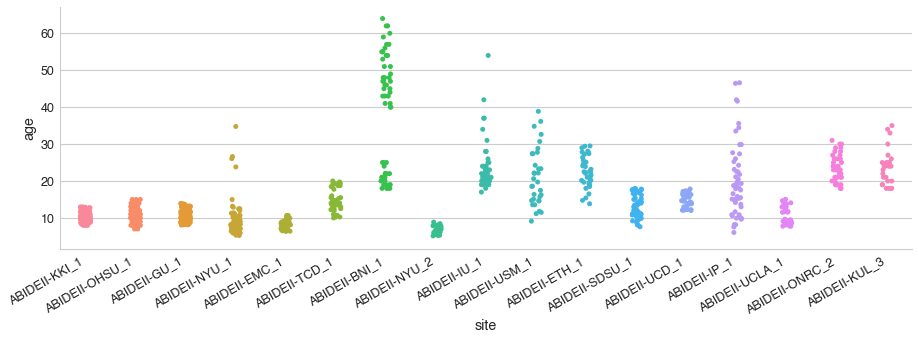

In [9]:
# Seaborn is a high-level plotting library that makes generation
# of complex, beautiful plots a snap.
g = sns.catplot(x='site', y='age', data=data, kind='strip')
g.set_xticklabels(rotation=30, horizontalalignment='right')
plt.gcf().set_size_inches((16, 4))

In the above plot, each strip is a different site, and each point is a single subject. As we can clearly see, sites do indeed vary wildly in their age distributions. For example, the NYU site scanned only very young children (< 10), whereas the BNI site scanned mostly adults over 40.

#### Predicting age residualized on site
The fact that site differences are so big is worrisome, in one one sense, as it raises the possibility that at least some of the predictive power of our model might derive from spurious associations between research site and our brain features—i.e., that if we were to "adjust" age to account for between-site differences, the brain features might no longer do quite as much work for us in predicting age.

There are various ways we can go about testing this. A simple but very conservative one (I explain why below) is to residualize age on research site. That is, we remove all the variance in age that can be explained by between-site differences.

To save time, I've included an already-residualized version of the age variable in our dataset; it's in the "age_resid" column. So we can just repeat our analysis above with `'age_resid'` instead of `'age'`:

In [10]:
# Same as before, except our y variable is now residualized age
r2_cv = cross_val_score(est, X_small, data['age_resid'], cv=5)

print("Individual fold scores:", r2_cv)
print(f"\nMean cross-validated R^2: {r2_cv.mean():.2f}")

Individual fold scores: [-0.29745994 -0.09671974 -0.07569208 -0.09211304 -0.0892036 ]

Mean cross-validated R^2: -0.13


Uh oh. It looks like once we residualize subjects' chronological age on research site, our current model is worthless. The brain-derived features appear to be add no incremental information to our age prediction beyond what we get just by knowing where each person was scanned.

#### Is it all for naught?
Does this mean we're fooling ourselves, and should just give up now? No! As noted above, this particular analysis is *extremely* conservative. Because the ABIDE-II sites differ so dramatically in age distributions, by controlling for research site, we're wiping out most of the variability in age. This would make it much harder to predict age from the brain features even if it was the site effects that were completely spurious. The root problem is that we can't tell, just from a set of correlations, what the correct causal model is.

The reality is that causal interpretation of observational data is hard, and cross-validation doesn't make it any easier. The question of whether or not we need to adjust for variables like site effects before examining the brain-age relationship isn't trivial (nor is deciding *how* to adjust for them). For the rest of this tutorial, we'll ignore the effects of research site, or of any other potential confounders, and just try to predict age directly from the brain variables. For what it's worth, this is actually a fairly reasonable approach. Just be aware that if we were planning to share these results with the result of the world (e.g., in a paper reporting what we've found), we'd probably need to think much more carefully about our causal assumptions, and maybe do some extra work to convince ourselves that there genuinely is a good deal of information about chronological age being carried by structural differences in people's brains.

## Learning and validation curves

So far, we've focused on cross-validating model performance at a single point in dataset and parameter space. That is to say, we're asking "how well would our fitted model do if we took it exactly as-is, changing none of its parameters, and applied it to a new dataset sampled from exactly the same population?"

This is an important thing to know, but we can do better. If we want to get deeper insights into a model's behavior, we need a good way to observe the way it responds when we systematically vary the size and nature of the data, number and type of features, model hyperparameters, etc.

In scikit-learn, we can use the `learning_curve` and `validation_curve` utilities to flexibly and compactly wrap most of the cross-validation functionality we've already encountered. The idea behind the [learning curve](https://en.wikipedia.org/wiki/Learning_curve_(machine_learning)) is to graphically display a model's predictive performance as a function of the model's experience—i.e., to visualize how well it learns as the available data grows. The `validation_curve` is directly analogous, except instead of varying the size of the data, we systematically vary one of the estimator's parameters.

Let's look at the `learning_curve` in more detail. Here's an example:

In [11]:
from sklearn.model_selection import learning_curve

# We'll use 100 random features as predictors.
X = X_all.sample(100, axis=1, random_state=100)

# The sizes of the samples we want to plot model performance for.
# Note that we can't go above 800, because we only have ~1,000
# cases, and we're using 80% of the sample for training.
train_sizes = [100, 200, 400, 800]

# We'll use a ridge regression estimator
est = LinearRegression()

# obtain learning curve. as with the cross_val_score utility,
# the cross-validated application of our estimator is done
# implicitly for us.
results = learning_curve(est, X, y, train_sizes=train_sizes,
                         cv=5, shuffle=True)
sizes, train_scores, test_scores = results

The `train_scores` and `test_scores` arrays contain the performance scores for training and testing data, respectively. The rows reflect training sizes (i.e., in our case, the first row gives performance n=100, the second for n=200, etc.) and the columns contain the scores from the <i>k</i> folds of the k-folds cross-validation procedure.

In [12]:
test_scores.round(2)

array([[-4.3662e+02, -5.5880e+01, -2.0490e+01, -5.8180e+01, -5.4876e+02],
       [ 2.8000e-01,  2.2000e-01,  1.3000e-01,  1.9000e-01,  9.0000e-02],
       [ 5.4000e-01,  5.2000e-01,  5.1000e-01,  4.5000e-01,  4.5000e-01],
       [ 6.1000e-01,  5.7000e-01,  5.2000e-01,  5.3000e-01,  5.4000e-01]])

This information is fairly hard to appreciate in tabular form, so let's average performance over the columns (i.e., the <i>k</i> folds) and plot it as a function of the sample size.

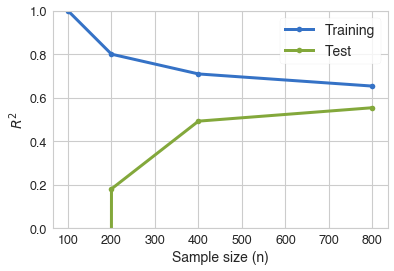

In [13]:
train_mean = train_scores.mean(1)
test_mean = test_scores.mean(1)

plt.plot(sizes, train_mean, 'o-', label='Training', lw=3)
plt.plot(sizes, test_mean, 'o-', label='Test', lw=3);
plt.grid(True, axis='y')
plt.legend(fontsize=14)
plt.ylim(0, 1)
plt.xlabel('Sample size (n)', fontsize=14)
plt.ylabel('$R^2$', fontsize=14);

We learn several things from this plot. First, our linear regression estimator overfits like crazy rampant with small samples: $R^2$ in the training samples is near 1 in the training sample, but is essentially 0 in the test sample. Second, and conversely, $R^2$ in the test sample improves monotonically as the training dataset gets larger. This is a general rule: on average, a model's out-of-sample performance should only get better as it's trained on more data. Third, note that the training and test curves never converge, even with the largest sample we have available. This suggests that we're still overfitting, and we might want to consider either acquiring more data (if possible) or reducing the model's flexibility (e.g., by using fewer features, or by using a different model less prone to overfitting).

#### Training vs. test vs. validation : a note on nomenclature
Before moving on, a quick note on nomenclature: you will sometimes hear people talk about "validation" sets rather than (or in addition to) training and test sets. What this means depends on the context. In many cases, the terms test set and validation set are used interchangeably to refer to a new dataset independently of the one the model is trained on. But sometimes, the distinction between validation and test is important. In particular, it's common to set aside a "true" hold-out dataset in advance of any validation efforts. In such cases, the test dataset is the one we use to obtain our final, no-takesies-backsies estimate of performance. The validation dataset, by contrast, is technically part of the training data (in that we allow ourselves to use it to train the final model), but it's being used for validation. When we perform a cross-validation procedure on a training set, we call the hold-out folds the validation sets.

This kind of 3-way split of our data is an excellent way to operate, as it ensures that we're able to detect overfitting that occurs not only during model estimation, but also in the model selection process (e.g., if we "cross-validate" 100 models and then choose the one with the best cross-validated performance, we're still going to overfit to some degree, and performance in the test dataset will reveal this).

<div align="center" style="font-size: 12px;">
<img src="images/trainvaltest.png">
Image from <a href="https://medium.com/@hi.martinez/train-test-split-cross-validation-you-b87f662445e1">https://medium.com/@hi.martinez/train-test-split-cross-validation-you-b87f662445e1</a>
</div>

### Dataset size and model complexity
So far we've looked at the relationship between training dataset size and model performance. Now we'll add another dimension to the picture, and try to get a qualitative sense of how our training and validation curves vary as a function of model complexity—which in this case we'll operationalize as the number of predictors our linear regression estimator gets to use. 

To save ourselves a lot of code, we'll use a `plot_learning_curves` helper function I've written that wraps the `learning_curve` utility we used to produce the curves in the previous plot. It'll enale us to easily generate plots with multiple panels, where each panel shows the learning curve when plotted for a different dataset and/or estimator.

Let's see how well we can predict age given three different sizes of feature sets: 5 features, 30 features, and 100 features. We'll once again evaluate performance for sample sizes ranging from 100 to 50,000. For the time being, we'll stick with ordinary least-squares regression as our estimator.

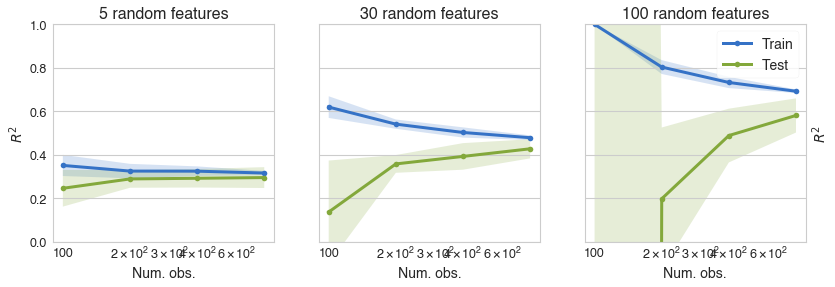

In [14]:
# the aforementioned plotting helper
from support import plot_learning_curves

# we'll compare performance for three different sets of predictors:
# 5 random features, 30 random features, and 100 random features.
X_5 = X_all.sample(5, axis=1, random_state=99)
X_30 = X_all.sample(30, axis=1, random_state=99)
X_100 = X_all.sample(100, axis=1, random_state=99)

X_sets = [X_5, X_30, X_100]

# training sizes remain the same in our previous examples
train_sizes = [100, 200, 400, 800]

# titles for each of the plot panels
labels = ['5 random features', '30 random features', '100 random features']

# we pass plot_learning_curves an estimator, the list of feature
# #sets, the outcome variable, and the train_sizes and labels
plot_learning_curves(LinearRegression(), X_sets, y, train_sizes, labels=labels)

There are a couple of new points to note here:

1. Our ability to predict age varies dramatically depending on how many features we use. Looking at the terminal point of each test curve (representing the K-fold cross-validated performance estimate at the largest sample size), we see that we do much better with 100 features than with 30, and much better with 30 than with 5.

2. When sample size is small, we actually do a better job predictively using a smaller set of features! For example, at n = 100, we can explain about 20% of the variance in the test set using 5 features, whereas our 100-feature model is basically useless. By contrast, if we paid attention solely to the (overfitted) training set estimates, we would be misled into thinking that the 100-feature model performs much better than the 5-feature model (~100% of the variance vs. < 40%). This illustrate sa general relationship between model complexity and dataset size: the more complex a model, the greater its capacity to learn from the data, but the more data we need in order to avoid overfitting. This tradeoff is unavoidable, and means that we need to think carefully (and conduct validation analyses like the one above!) when constructing our model.